This file represents a full analysis on a given task. For purpose of presenting the results, Jupyter notebook was chosen.

In [1]:
from functions import *

# Load data

In [2]:
# Load data
df_all, df1, df2, df3 = load_data(data_path_jup)
columns = list(df1.columns)

Load data
8949 (4.8%) duplicates dropped
24575 (4.8%) duplicates dropped
20026 (4.7%) duplicates dropped
Data loaded 



In [3]:
df_all.head()

,video_id,subject_id,frame_no,millisecond_from_start,positive_1,positive_2,negative_1,negative_2,negative_3
0,67928,12185283,370,5,0,0,0,0,0
1,67928,12185283,371,37,0,0,0,0,0
2,67928,12185283,372,69,0,0,0,0,0
3,67928,12185283,373,102,0,0,0,0,0
4,67928,12185283,374,133,0,0,0,0,0


###### First look at the data 

In [4]:
print('Each data file corresponds to only one video')
print(set(df1.video_id), set(df2.video_id), set(df3.video_id))
print('')

print('Each subject watched only one video, therefore we can group by subject_id')
print(set(df1.subject_id) & set(df2.subject_id))
print(set(df2.subject_id) & set(df3.subject_id))
print('')

print("no Nan values, missing values are labeled as 'No value'")
print(df_all.isnull().values.any())

Each data file corresponds to only one video
{'67928', 'No value'} {'70727', 'No value'} {70728}

Each subject watched only one video, therefore we can group by subject_id
{'No value'}
set()

no Nan values, missing values are labeled as 'No value'
False


###### Missing values: first look

The only non-numeric values is 'No value'.

Values from sets {video_id, subject_id} and {emotions} are equal to 'No value' together.<br>
For example, if video_id == 'No value', then subject_id == 'No value' as well. Same for emotions: if any emotion is missing, then all are missing.

Here we print for each video:<br>
non-numeric values and their proportion

In [5]:
print('video 1')
no_value(df1)
print('')

print('video 2')
no_value(df2)
print('')

print('video 3')
no_value(df3)
print('')

print('video all')
no_value(df_all)
print('')

video 1
['No value'] 1%
['No value'] 1%
[] 0%
[] 0%
['No value'] 23%
['No value'] 23%
['No value'] 23%
['No value'] 23%
['No value'] 23%

video 2
['No value'] 1%
['No value'] 1%
[] 0%
[] 0%
['No value'] 26%
['No value'] 26%
['No value'] 26%
['No value'] 26%
['No value'] 26%

video 3
[] 0%
[] 0%
[] 0%
[] 0%
['No value'] 29%
['No value'] 29%
['No value'] 29%
['No value'] 29%
['No value'] 29%

video all
['No value'] 1%
['No value'] 1%
[] 0%
[] 0%
['No value'] 27%
['No value'] 27%
['No value'] 27%
['No value'] 27%
['No value'] 27%



# Feature engineering

## Missing values

In [6]:
# label missing id values
df_all['no_value_id'] = df_all['subject_id'].apply(lambda x: 1 if str(x) == 'No value' else 0)
# label missing emotion values
df_all['no_value_emotion'] = df_all['positive_1'].apply(lambda x: 1 if str(x) == 'No value' else 0)

In [7]:
df_all.head()

,video_id,subject_id,frame_no,millisecond_from_start,positive_1,positive_2,negative_1,negative_2,negative_3,no_value_id,no_value_emotion
0,67928,12185283,370,5,0,0,0,0,0,0,0
1,67928,12185283,371,37,0,0,0,0,0,0,0
2,67928,12185283,372,69,0,0,0,0,0,0,0
3,67928,12185283,373,102,0,0,0,0,0,0,0
4,67928,12185283,374,133,0,0,0,0,0,0,0


### video and subject ids

###### replace missing id values

Replace 'No value' entries by preceding/following value if the 'frame_no' changes by 1 with respect to previous/next value.

In [8]:
df_all.update(replace_no_value_id(df_all))

All id missing values were successfully replaced 



### emotions

###### plot statistics on missing emotion values


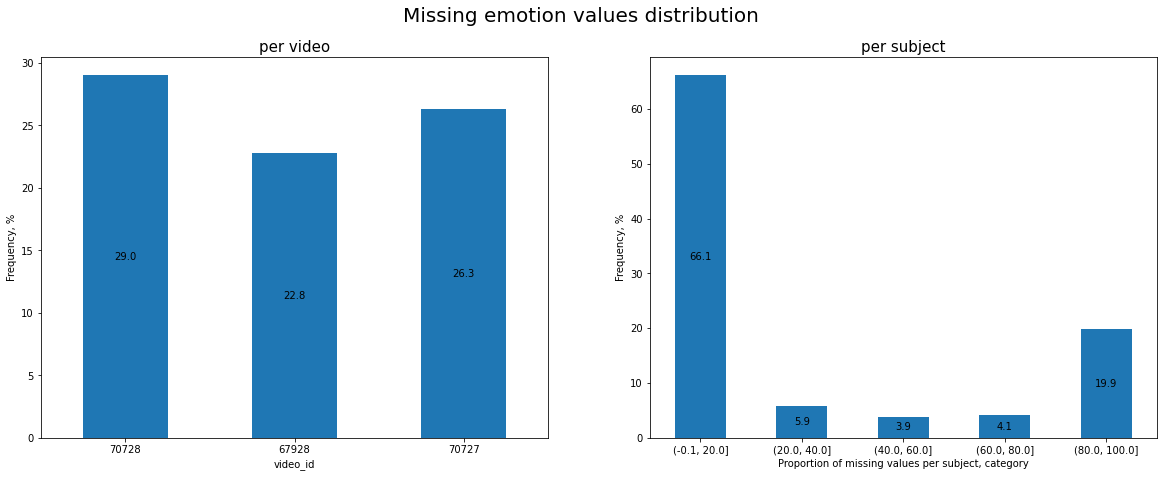

In [9]:
plot_no_value_emotion(df_all)

###### remove missing emotion values

In [10]:
# remove subjects with the proportion of missing emotion data > a given threshold
df_all = remove_subjects_no_value_emotion(df_all, threshold=30)
# remove missing values
df_all = df_all.drop(df_all[df_all['no_value_emotion'] == 1].index)
df_all = df_all[columns]

Video ID 	 Proportion of removed subjects per each video, in %
70728    34.5
70727    28.8
67928    27.9
Name: removed, dtype: float64
In total it was removed 30.7% of subjects 



## Basics

###### convert to integer

In [11]:
for c in columns:
    df_all[c] = pd.to_numeric(df_all[c])
    df_all[c] = df_all[c].astype('int32')

###### sort and remove duplicates

In [12]:
df_all = df_all.sort_values(by=['video_id', 'subject_id', 'frame_no', 'millisecond_from_start'], ignore_index=True)
df_all = remove_duplicates(df_all)
print('')

36166 (4.8%) duplicates dropped



###### create new features

In [13]:
# number of frames for each subject
df_all['no_of_frames'] = df_all.groupby(['subject_id'])['subject_id'].transform('size')
# time interval between captured frames
df_all['time_diff'] = df_all.groupby(['subject_id'])['millisecond_from_start'].transform('diff')

# Data analysis

In [14]:
size = df_all.shape[0]

## Video length
Videos are at least 30, 53 and 46 seconds long

In [15]:
print('max:')
print(df_all.groupby('video_id')['millisecond_from_start'].max())
print('')
print('min:')
print(df_all.groupby('video_id')['millisecond_from_start'].min())
print('')

max:
video_id
67928    29999
70727    53000
70728    46000
Name: millisecond_from_start, dtype: int32

min:
video_id
67928    0
70727    0
70728    0
Name: millisecond_from_start, dtype: int32



## Sample size
Samples are more or less statistically significant.

For example, given population = 1M, Margin of error=5%, conf.level 90%/ 95% ideal sample size would be 271/384

In [16]:
print('Sample size:')
print('')
print(df_all.groupby('video_id')['subject_id'].nunique(), '\n')

Sample size:

video_id
67928    245
70727    332
70728    312
Name: subject_id, dtype: int64 



## Number of frames distribution

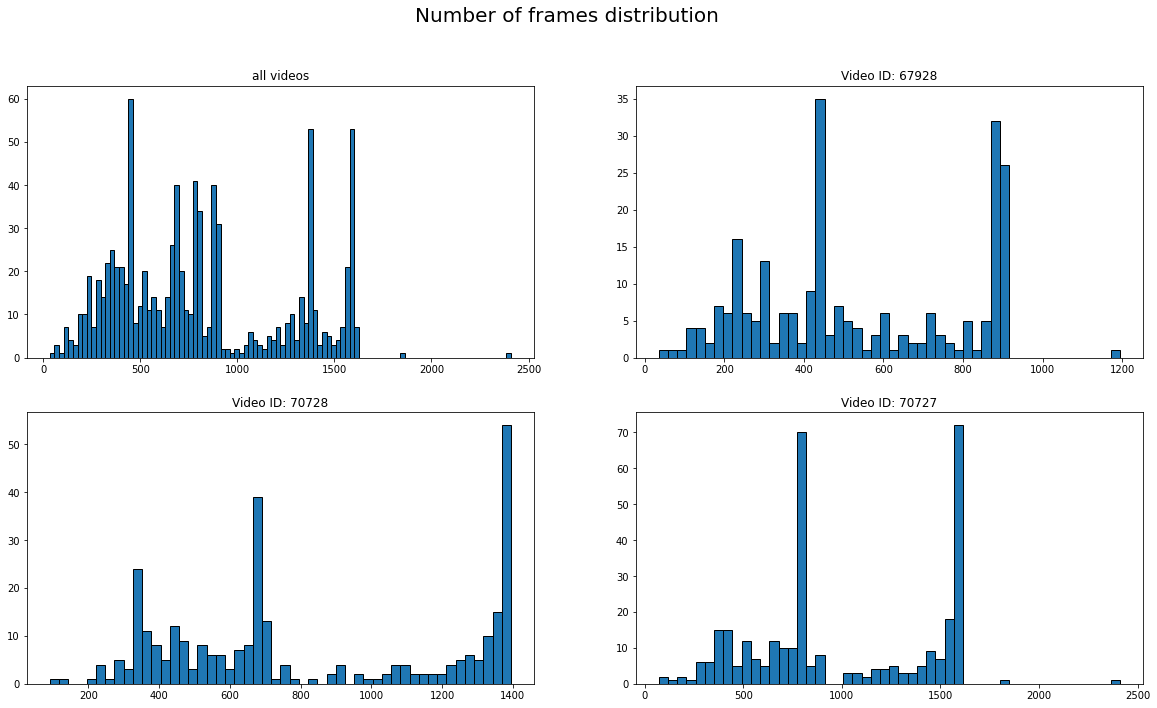

In [17]:
plot_num_of_frames(df_all, bins=(100, 50))

## Time distribution

more or less enough data

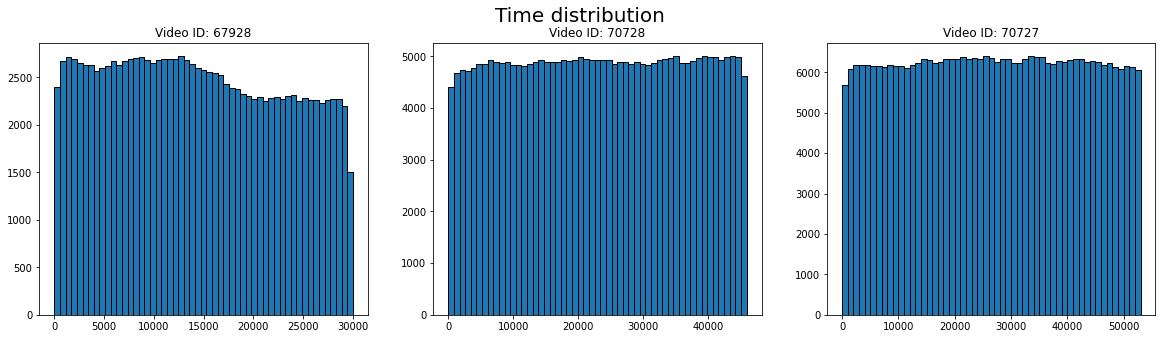

In [18]:
plot_time(df_all, bins=53)

## Time intervals between frames

In [19]:
print(df_all['time_diff'].describe(), '\n')

count    719794.000000
mean         53.199872
std         104.447073
min           1.000000
25%          32.000000
50%          34.000000
75%          64.000000
max       23218.000000
Name: time_diff, dtype: float64 



66229


array([[<AxesSubplot:title={'center':'time_diff'}>]], dtype=object)

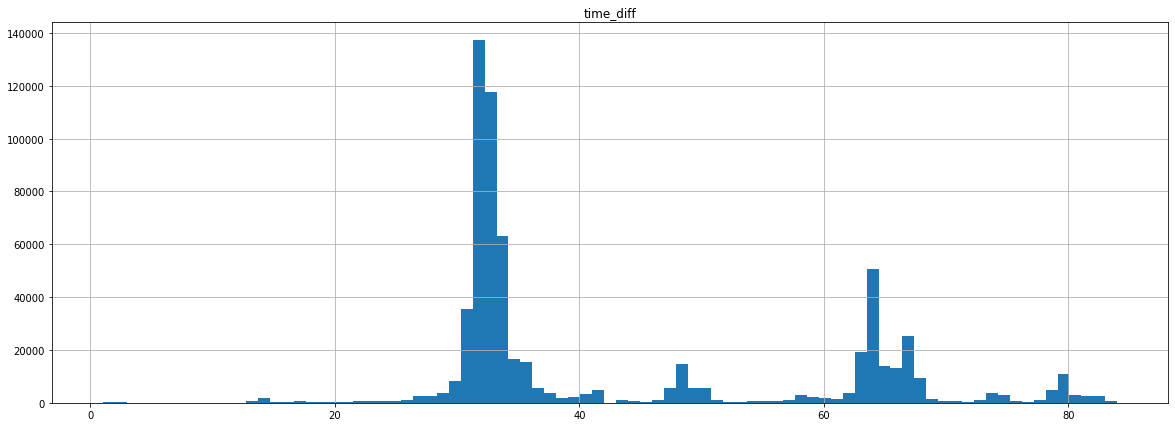

In [20]:
# Plot distribution

n=85
print(df_all[df_all.time_diff>=n].shape[0])
df_all[df_all.time_diff<n][['time_diff']].hist(bins=85, figsize=(20,7))

## Strategy

If one plots evolution of subject's emotional response over time, then the plot would look like a cardio diagram with peaks
corresponding to emotional response.

We see that distribution of number of frames is very diverse: there are many subjects with small amount of frames.
Those subjects might bring bias when calculating average emotion for each subject because of their bad coverage - when a time step is too big, peaks will be missed.

However, time distribution shows that it's enough data for each of the time bin. When the step is chosen to be small, this provides a good coverage (close to continuous).

Thus, the chosen strategy is to calculate the average emotion for each bin as a first step, and then compare the plots or
average over the beans to produce a single score.

## Emotions

To choose a metric, let us look at combinations of emotions from the same class.

Most of captured frames show no emotions.

This is hard to explain without knowing how the emotion information algorithm works. 
Since most frames change mostly with frequency ~32 and ~ 65 ms, I would expect a much lower proportion of 'no emotion' signals. 
Normally, emotion freezes on a subject's face until a new emotion appear: as for example we continue smiling for some long time after we experienced a funny moment. 
However, a signal from the algorithm might show only emotional change. This would explain to me the result.

In [21]:
# Count emotions

emotions = ['positive_1', 'positive_2', 'negative_1', 'negative_2', 'negative_3']

df_all['positive_count'] = df_all[emotions[:2]].sum(axis=1)
df_all['negative_count'] = df_all[emotions[-3:]].sum(axis=1)
df_all['emotions_count'] = df_all[emotions].sum(axis=1)

print('Positive emotions:')
print(round(df_all['positive_count'].value_counts().sort_index()/size*100, 1), '\n')

print('Negative emotions:')
print(round(df_all['negative_count'].value_counts().sort_index()/size*100, 1), '\n')

print('All emotions:')
print(round(df_all['emotions_count'].value_counts().sort_index()/size*100, 1), '\n')


Positive emotions:
0    92.3
1     7.5
2     0.2
Name: positive_count, dtype: float64 

Negative emotions:
0    92.3
1     7.3
2     0.4
3     0.0
Name: negative_count, dtype: float64 

All emotions:
0    85.3
1    13.4
2     1.2
3     0.1
4     0.0
Name: emotions_count, dtype: float64 



## Metrics

The proposed definitions to compute the features per frame are:
1. *positive_1 + positive_2 - ( negative_1 + negative_2 + negative_3 )*
2. *any( positive_1, positive_2) - any( negative_1, negative_2, negative_3 )*
3. *any( positive_1, positive_2, negative_1, negative_2, negative_3 )*

**values:**
1. {-3, -2, -1, 0, 1, 2}
2. {-1, 0, 1}
3. {0, 1}

**pros & cons:**
1. **+:** takes into account all emotions; detects a class (pos or neg) <br> **&#8722; :** not balanced; 1 pos kills 1 neg
2. **+:** balanced; detects a class (pos or neg) <br> **&#8722; :** doesn't take into account all emotions but a class; 1 pos kills 1 neg
3. **+:** detect if there is an emotion (1 pos not kills 1 neg); <br> **&#8722; :** does not detect a class (pos or neg)

As was mentioned, presence of many emotions at the same time is very rare, so it is expected that metrics 1 and 2 will give approximately the same result.

There is no information on a use case given, as well as on the emotions. <br>

Suppose, one is interested in detecting whether a video causes any emotion (this can be used to measure whether a video attracts attention). Then I would choose metric 3. Metrics 1 and 2, in turn, will miss moments which cause positive and negative emotions at the same time resulting in neutral signal. In addition, if one needs to measure the strength of emotional outburst without paying attention to emotional colouring, I would go for a sum of all emotions (modified metric 1).

Suppose, we are interested in the emotional colouring of the video rather then presence of any emotion. In this case, I would go for metrics 1 or 2 since they give approximately same results. One weak point of both metrics is the assumption that the metrics are equivalent. In general, given more information on emotions (name, importance, ...) I would choose metric 1 with weights added. Weights would try to balance the sum and take into account the importance of each emotion.

Not relevant! Thoughts on the unequal nature of emotions: <br>
Which emotions lead our decision? The question is quite intresting. I think it might depend on a video nature, purpose/business and audience it is addressed to. Without researching, I can say that on my experience people tend to remember negative experience rather then positive. So negative emotion might be stronger. But, the decision changes very fast if there is not much choice. For example, a hungry person will be lazy to go to another cafe for lunch even if the stuff is unfriendly and the atmosphere isn't very nice. The person will complain a bit but still eat the food. But most probably, he will never come back.

In [22]:
# Split the dataset into time bins of 1 second length
bins_no = 53
df_all['time_bin'] = pd.cut(df_all['millisecond_from_start'], bins=bins_no, labels=list(range(1, bins_no+1)))


# Compute metrics
metrics = ['metric_{}'.format(i) for i in [1, 2, 3]]
df_all['metric_1'] = df_all['positive_count'] - df_all['negative_count']
df_all['metric_2'] = df_all[emotions[:2]].any(axis=1).astype(int) - \
                     (df_all[emotions[-3:]].any(axis=1)).astype(int)
df_all['metric_3'] = df_all[emotions].any(axis=1).astype(int)


# Compute average emotion for each time bin
metrics_avg = ['metric_{}_avg'.format(i) for i in [1, 2, 3]]
for i in [1, 2, 3]:
    df_all['metric_{}_avg'.format(i)] = df_all.groupby(['video_id', 'time_bin'])['metric_{}'.format(i)].transform('mean')

df_emotion = df_all[['video_id', 'time_bin']+metrics_avg].drop_duplicates()

###### Emotion evolution

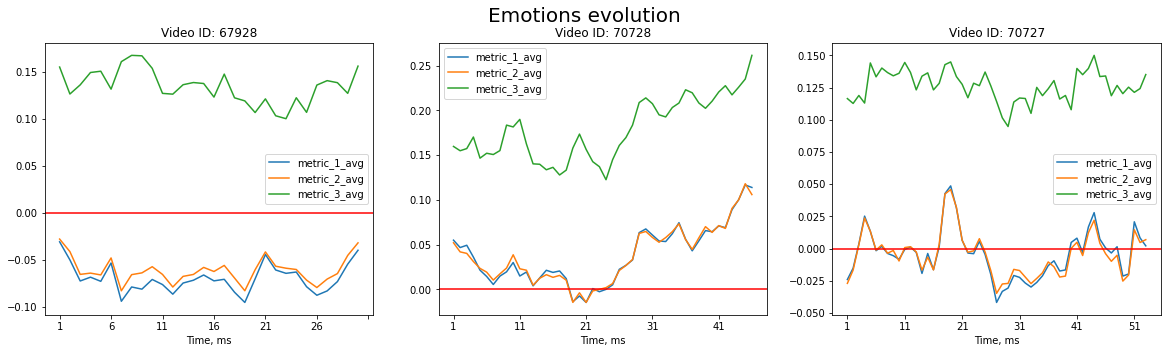

In [23]:
plot_emotion_evolution(df_emotion, metrics=metrics_avg, compare=None)

###### Compare the metrics

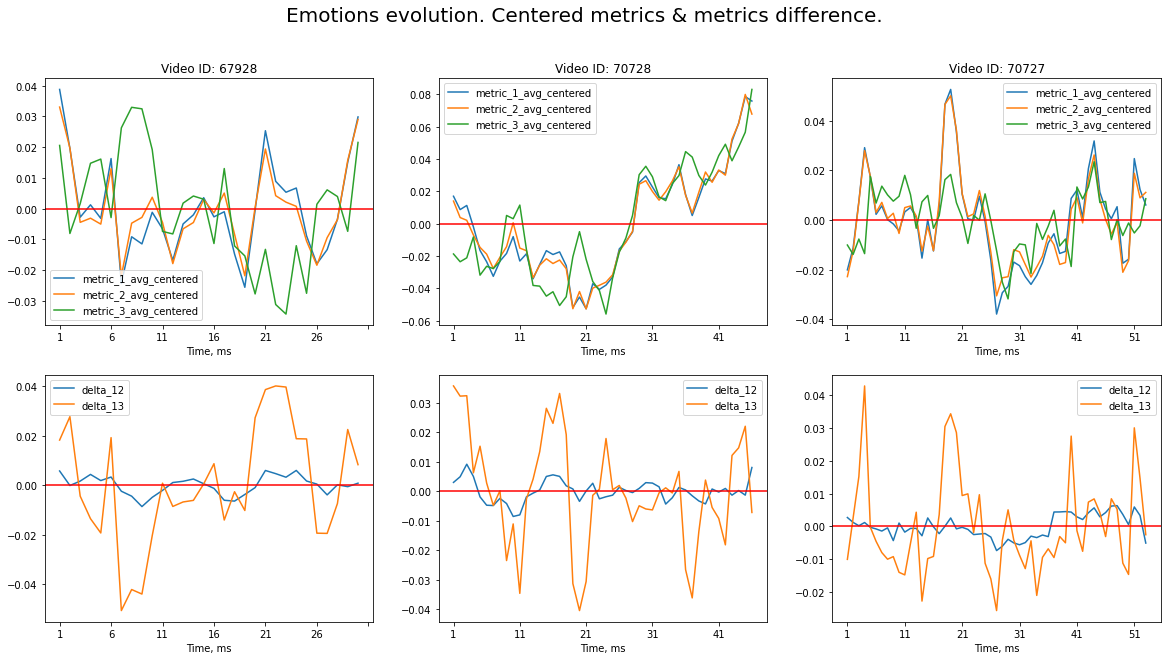

In [24]:
# All the metrics are centered (substract the mean) and difference between metrics is computed
plot_emotion_evolution(df_emotion, metrics=metrics_avg, compare='metrics')

###### Compare the videos

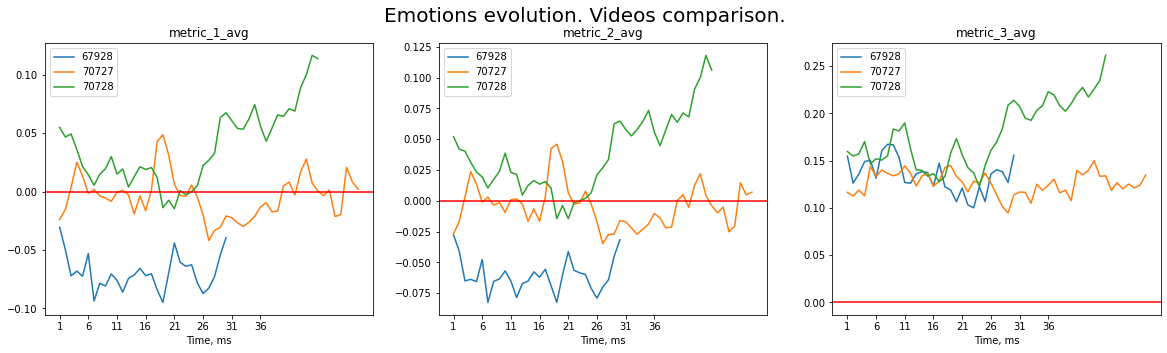

In [25]:
plot_emotion_evolution(df_emotion, metrics=metrics_avg, compare='videos')

###### Total emotion score

Compute total emotion score for each video as an average value of a the corresponding metric

In [26]:
for m, m_a in zip(metrics, metrics_avg):
    df_emotion[m+'_total'] = df_emotion.groupby('video_id')[m_a].transform('mean')
    
df_emotion_final = df_emotion[['video_id', 'metric_1_total', 'metric_2_total', 'metric_3_total']].drop_duplicates().reset_index().round(3)
df_emotion_final

,index,video_id,metric_1_total,metric_2_total,metric_3_total
0,0,67928,-0.069,-0.061,0.134
1,137734,70727,-0.004,-0.004,0.126
2,485233,70728,0.038,0.038,0.178


# Conclusion

1. As expected, metrics 1 and 2 give similar results.
2. Metric 3 is different from metrics 1 and 2 - it detects only if a video causes any emotion without paying attention to emotional colouring. 
3. In a given data set, most of emotional non-neutral responses contain only single emotion. Thus, metric 3 has no advantage over metrics 1/2 since it can be obtained by simply flipping the negative parts of the latter one.
4. As a summary, for our data set I would stop at metric 1/2. Given more information about the emotions (meaning, importance,..) sum of **weighted** emotions would be the best option.
5. In principle, total score helps to differintiate the videos. However, it does not help to differentiate the dynamics:
    - metric 1/2 shows that videos 70727 & 70728 are quite neutral during the first half, but differ significantly during the second half - also from the ID I suppose that they are different versions of one video
    - in turn, video 67928 is rather negative in nature.
